# Dependencies

In [2]:
%%capture
#!pip install -U transformers

In [3]:
# Standard library imports
import os
import time
import re
import random
from matplotlib import pyplot as plt
from tabulate import tabulate
from pprint import pprint

# Third-party library imports
import pandas as pd
import numpy as np
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import csv

# Google Colab imports
from google.colab import drive
from google.colab import userdata

# Kaggle imports
#from kaggle_secrets import UserSecretsClient

In [4]:
# Google Colab
#drive.mount('/content/drive')
#HF_TOKEN = userdata.get('HF_TOKEN')
#data_folder = '/content/drive/MyDrive/ADSP/data/'
#output_folder = data_folder

Mounted at /content/drive


In [ ]:
# Kaggle
#user_secrets = UserSecretsClient()
#HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
#data_folder = '/kaggle/input/data-csv/'
#output_folder = '/kaggle/working/'

In [5]:
def build_LLM(model_name, token):
    """
    Carica il modello e il tokenizer, allocando il modello automaticamente sul dispositivo corretto.
    """
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        token=token
    )

    print(f"Model memory footprint: {model.get_memory_footprint() / 1e9:.2f} GB")

    tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
    print(f"Vocabulary size of tokenizer: {tokenizer.vocab_size}")

    return model, tokenizer

In [6]:
def build_prompt(task, system_prompt, examples, consumer_feedbacks, tokenizer):

    # Default system prompt if not provided
    system_prompt = system_prompt or "You are a friendly and helpful assistant."
    n_feedbacks = len(consumer_feedbacks)
    # Generate concatenated examples and feedbacks based on the task
    if task == 'relevance_classification':
        concatenated_examples = "\nLook at these examples:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}' | LABEL: {label}" for i, (feedback, label) in enumerate(examples)]
        ) + "\n" if examples else ""
        concatenated_feedbacks = f"\nClassify the following {n_feedbacks} FEEDBACKS:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}'" for i, feedback in enumerate(consumer_feedbacks)]
        ) + "\n"
        response_structure = ("Respond strictly with: 1 or 0. **Always** use the following format:\n"
        "FEEDBACK 1: 'text_of_the_feedback' | LABEL: 1\n"
        "FEEDBACK 2: 'text_of_the_feedback' | LABEL: 0\n"
        "FEEDBACK 3: 'text_of_the_feedback' | LABEL: 1\n")

    elif task == 'multitopic_sentiment_classification':
        concatenated_examples = "\nLook at these examples:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}' | POSITIVE TOPICS: {positive} | NEGATIVE TOPICS: {negative} "
             f"| PRIMARY POSITIVE ASPECT: {primary_pos}| PRIMARY NEGATIVE ASPECT: {primary_neg}\n"
             for i, (feedback, positive, negative, primary_pos, primary_neg) in enumerate(examples)]
        ) + "\n"  if examples else ""
        concatenated_feedbacks = f"\nClassify the following {n_feedbacks} FEEDBACKS:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}'" for i, feedback in enumerate(consumer_feedbacks)]
        ) + "\n"
        response_structure = ("\nPlease, for each FEEDBACK, respond exclusively in the following format:\n"
        "FEEDBACK i: ['text of the feedback'] | POSITIVE TOPICS: [list of positive categories, e.g., ['Coffee Quality', 'Brand Awareness']] | NEGATIVE TOPICS: [list of negative categories, e.g., ['Machine Performance']] | PRIMARY POSITIVE ASPECT: [main positive aspect, e.g., 'Rich and smooth crema'] | PRIMARY NEGATIVE ASPECT: [main negative aspect, e.g., 'Noisy machine']\n"
        "If an element is not present, always write 'NONE'. ALWAYS provide a response!\n")


    elif task == 'sentiment_classification':
        concatenated_examples = "\nLook at these examples:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}' | SENTIMENT: {sentiment}"
             for i, (feedback, sentiment) in enumerate(examples)]
        ) + "\n"  if examples else ""
        concatenated_feedbacks = f"\nClassify the following {n_feedbacks} FEEDBACKS:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}'" for i, feedback in enumerate(consumer_feedbacks)]
        ) + "\n"
        response_structure = ("\nRespond strictly with: Positive, Neutral or Negative. **Always** use the following format:\n"
        "FEEDBACK 1: 'text_of_the_feedback' | SENTIMENT: Positive\n"
        "FEEDBACK 2: 'text_of_the_feedback' | SENTIMENT: Neutral\n"
        "FEEDBACK 3: 'text_of_the_feedback' | SENTIMENT: Negative\n")

    elif task == 'star_rating':
        concatenated_examples = "\nLook at these examples:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}' | RATING: {rating}"
             for i, (feedback, rating) in enumerate(examples)]
        ) + "\n"  if examples else ""
        concatenated_feedbacks = f"\nClassify the following {n_feedbacks} FEEDBACKS:\n" + "\n".join(
            [f"FEEDBACK {i+1}: '{feedback}'" for i, feedback in enumerate(consumer_feedbacks)]
        ) + "\n"
        response_structure = ("\nRespond strictly with: 1, 2, 3, 4, 5. **Always** use the following format:\n"
        "FEEDBACK 1: 'text_of_the_feedback' | RATING: 1\n"
        "FEEDBACK 2: 'text_of_the_feedback' | RATING: 4\n"
        "FEEDBACK 3: 'text_of_the_feedback' | RATING: 2\n")

    else:
      raise ValueError("Invalid task. Must be one of 'relevance_classification', 'multitopic_sentiment_classification', 'sentiment_classification', or 'star_rating'.")

    # Create the user message content
    user_message_content = (
        f"{system_prompt}"
        f"{concatenated_examples}"
        f"{concatenated_feedbacks}"
        f"{response_structure}\n"
    )

    # Build the messages list
    messages = [{"role": "user", "content": user_message_content}]

    # Generate the final prompt
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    return prompt

In [7]:
def generate_response(task, prompt, n_feedbacks, max_tokens=1024, temperature=0.3):
    """
    Generate a model response from a given prompt.
    """
    try:
        # Tokenize the input prompt and ensure it is on the same device as the model
        inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)

        # Repeat until valid output is generated
        while True:
            # Generate the model's output with controlled sampling parameters
            outputs = model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],  # Pass attention mask explicitly
                max_new_tokens=max_tokens,
                temperature=temperature,
                do_sample=True,  # Enable sampling for temperature
                pad_token_id=tokenizer.eos_token_id  # Ensure padding is handled correctly
            )

            # Decode the generated tokens into human-readable text
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

            # clean the generated text
            cleaned_text = generated_text.strip().split(f"\nClassify the following")[1]

            # Process the generated text based on the task type
            cleaned_output = process_task_output(task, cleaned_text)

            # Check if the output meets the expected number of feedbacks
            if len(cleaned_output) == n_feedbacks:
                return cleaned_output
            else:
                #print(generated_text)
                print(f"Output does not match expected feedback count. Expected {n_feedbacks}, but got {len(cleaned_output)}. Retrying...")
                temperature = np.random.choice([0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

    except Exception as e:
        # Handle potential errors gracefully
        print(f"An error occurred while generating the response: {e}")
        return []

def process_task_output(task, generated_text):
    """
    Process the generated text based on the specified task.
    """
    if task == 'relevance_classification':
        # Extract binary labels (0 or 1)
        pattern = r"\| LABEL: (0|1)"
        matches = re.findall(pattern, generated_text)
        return [int(label) for label in matches]

    elif task == 'multitopic_sentiment_classification':
        # Extract positive/negative topics and primary aspects
        pattern = r"\| POSITIVE TOPICS: \[?\s*(.*?)\s*\]?\s*\| NEGATIVE TOPICS: \[?\s*(.*?)\s*\]?\s*\| PRIMARY POSITIVE ASPECT: \[?\'?\s*(.*?)\s*\'?\]?\s*\| PRIMARY NEGATIVE ASPECT: \[?\'?\s*(.*?)\s*\'?\]?"

        matches = re.findall(pattern, generated_text)
        return [
            {
                "positiveTopicClass": [topic.strip().replace("'", "") for topic in positive.split(",") if topic.strip()] or ["NONE"],
                "negativeTopicClass": [topic.strip().replace("'", "") for topic in negative.split(",") if topic.strip()] or ["NONE"],
                "primaryPositiveAspect": primary_pos.strip() if primary_pos.strip() else "NONE",
                "primaryNegativeAspect": primary_neg.strip() if primary_neg.strip() else "NONE"
            }
            for positive, negative, primary_pos, primary_neg in matches
        ]


    elif task == 'sentiment_classification':
        # Extract sentiment (Positive, Neutral, or Negative)
        pattern = r"\| SENTIMENT: (Positive|Neutral|Negative)"
        matches = re.findall(pattern, generated_text)
        return [sentiment for sentiment in matches]

    elif task == 'star_rating':
        # Extract star ratings (1 to 5)
        pattern = r"\| RATING: (1|2|3|4|5)"
        matches = re.findall(pattern, generated_text)
        return [int(rating) for rating in matches]

    else:
        # Raise an error for invalid task types
        raise ValueError("Invalid task. Must be one of 'relevance_classification', 'multitopic_sentiment_classification', 'sentiment_classification', or 'star_rating'.")


# Product Relevant-Comment Classification

In [ ]:
# System prompt definition
system_prompt = (
    "You are an expert assistant tasked with classifying user comments (feedbacks) as 'related' (1) or 'not related' (0) to the Lavazza A Modo Mio coffee machines.\n"
    "The Lavazza A Modo Mio coffee machines offer a versatile range of capsule-based systems "
    "combining Italian tradition, innovation, and sustainability to deliver premium espresso "
    "and milk-based drinks at home. Designed for ease of use, these machines feature intuitive interfaces "
    "customizable coffee dosing, and compatibility with Lavazza A Modo Mio capsules to ensure consistent "
    "high-quality Italian coffee. Highlights include compact and elegant designs, silent operation (≤49 dB) "
    "quick brewing times, and options for milk frothing, long coffee preparation, and smart home integration "
    "with Alexa. Catering to both eco-conscious and style-focused users, Lavazza machines seamlessly blend "
    "performance, convenience, and aesthetics, offering solutions for every coffee lover.\n\n"
    "A comment is 'related' (1) if it explicitly or implicitly refers, positively or negatively, to the coffee machine, its company, or these aspects:\n"
    "- **Coffee Quality**: Taste, consistency, crema, strength, or temperature.\n"
    "- **Machine Performance**: Brewing, speed, reliability, noise, or malfunctions.\n"
    "- **Capsules and Compatibility**: Capsule type, materials, or usability.\n"
    "- **Design and Materials**: Appearance, size, color, durability, or materials.\n"
    "- **User Experience**: Usability, interface, or smart features.\n"
    "- **Maintenance and Durability**: Cleaning, lifespan, or parts like frothers and tanks.\n"
    "- **Services and Logistics**: Delivery, customer service, or availability.\n"
    "- **Environmental Impact**: Sustainability or eco-friendly features.\n"
    "- **Brand Awareness**: Brand mentions or reputation.\n"
    "- **Price & worth**: Cost, value, or comparisons.\n\n"
    "- **General comment**: any comment that does not refer to anything in particular but expresses a sentiment.\n\n"
    "A comment is 'not related' (0) if it refers to unrelated products, off-topic remarks, or general question.\n"
)

# Examples for context, including both positive and negative cases
examples = [
    ("This machine makes creamy and delicious coffee every time.", 1),
    ("Poor customer service", 1),
    (":red_heart: Absolutely loving", 1),
    ("The water tank is too small, I have to refill it twice a day.", 1),
    ("@username1 @username2", 0),
    ("Price?", 0),
    ("Info thanks", 0),
    (":thumbs_up: Great experience with their dishwasher.", 0)
]

## Test Phase

In [ ]:
# Load Synthetic Comments
synthetic_comments_df = pd.read_csv(data_folder+'synthetic-comments.csv', sep='\t')
synthetic_comments_df.shape

(236, 6)

In [ ]:
# Count the number of records with label 0 and label 1
label_0_count = synthetic_comments_df[synthetic_comments_df['label'] == 0].shape[0]
label_1_count = synthetic_comments_df[synthetic_comments_df['label'] == 1].shape[0]

print(f"Number of records with label 0: {label_0_count}")
print(f"Number of records with label 1: {label_1_count}")

Number of records with label 0: 101
Number of records with label 1: 135


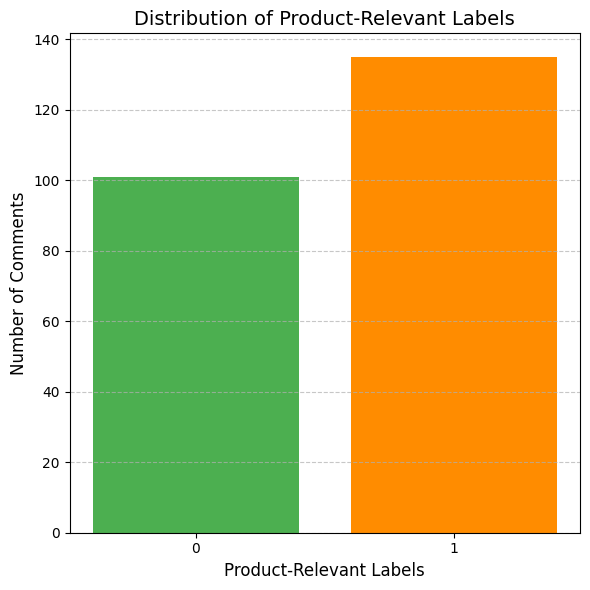

In [ ]:
# Calculate sentiment counts
sentiment_counts = synthetic_comments_df['label'].value_counts()

# Set up the figure and axis
plt.figure(figsize=(6, 6))

# Plot the bar chart with new custom colors
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#FF8C00', '#4CAF50'])  # Using new colors

# Add labels and title
plt.xlabel("Product-Relevant Labels", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Distribution of Product-Relevant Labels", fontsize=14)

# Customize x-ticks to display labels properly
plt.xticks(sentiment_counts.index, rotation=0)

# Show gridlines only on the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for tight fit
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# For this task we consider only label (relevance label)
test_df = synthetic_comments_df[['text', 'label']]

In [ ]:
def compute_metrics(true_labels, pred_labels):

    # Calculate and print performance metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division=0)  # Avoid warning for undefined precision
    recall = recall_score(true_labels, pred_labels, zero_division=0)  # Avoid warning for undefined recall
    f1 = f1_score(true_labels, pred_labels, zero_division=0)  # Avoid warning for undefined F1-score

    metrics_table = [
        ["Accuracy", f"{accuracy:.3f}"],
        ["Precision", f"{precision:.3f}"],
        ["Recall", f"{recall:.3f}"],
        ["F1 Score", f"{f1:.3f}"]
    ]

    print(tabulate(metrics_table, headers=["Metric", "Score"], tablefmt="grid"))
    print()

    # Confuzion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    cm_table = [[""] + [f"Pred Class {i}" for i in range(len(cm))]]
    for i, row in enumerate(cm):
        cm_table.append([f"True Class {i}"] + [str(val) for val in row])

    print("Confusion Matrix:")
    print(tabulate(cm_table, headers="firstrow", tablefmt="grid"))
    print("\n" + "-"*50)


In [ ]:
# Product Relevance Classificatioin Test Function
def test(model, tokenizer, test_df, task=None, system_prompt=None, examples=None, batch_size=5):

    comments = list(test_df['text'])
    true_labels =  list(test_df['label'])

    # Shuffle comments and labels together
    combined = list(zip(comments, true_labels))
    random.shuffle(combined)
    comments, true_labels = zip(*combined)

    # Predictions
    pred_labels = []

    # Process the comments in batches
    for i in tqdm(range(0, len(comments), batch_size), total=(len(comments) // batch_size) + (len(comments) % batch_size > 0), desc="TEST: Product Relevant-Comment Classification"):
        batch_comments = comments[i : i + batch_size]
        batch_labels = true_labels[i : i + batch_size]  # True labels for this batch

        # Generate the predicted labels for the current batch
        prompt = build_prompt(task, system_prompt, examples, batch_comments, tokenizer)
        response = generate_response(task, prompt, n_feedbacks=len(batch_labels)+3)[3:]
        pred_labels.extend(response)

        # Free the GPU
        del batch_comments
        del batch_labels
        del prompt
        del response
        gc.collect()
        torch.cuda.empty_cache()

    # Calculate and print performance metrics
    compute_metrics(true_labels, pred_labels)

### Gemma2-9B-it

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "google/gemma-2-9b-it"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model memory footprint: 18.48 GB
Vocabulary size of tokenizer: 256000


In [ ]:
# Batch_size:15, Gemma 0-shot

print("Gemma 0-shot")
test(model, tokenizer, test_df, task='relevance_classification', system_prompt=system_prompt, examples=None, batch_size=15)

In [ ]:
"""Gemma 0-shot
TEST: Product Relevant-Comment Classification:   0%|          | 0/16 [00:00<?, ?it/s]The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
TEST: Product Relevant-Comment Classification: 100%|██████████| 16/16 [13:24<00:00, 50.29s/it]+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |   0.758 |
+-----------+---------+
| Precision |   0.738 |
+-----------+---------+
| Recall    |   0.896 |
+-----------+---------+
| F1 Score  |   0.809 |
+-----------+---------+

Confusion Matrix:
+--------------+----------------+----------------+
|              |   Pred Class 0 |   Pred Class 1 |
+==============+================+================+
| True Class 0 |             58 |             43 |
+--------------+----------------+----------------+
| True Class 1 |             14 |            121 |
+--------------+----------------+----------------+"""

In [ ]:
# Batch_size:15, Gemma Few-shot

print("Gemma Few-shot")
test(model, tokenizer, test_df, task='relevance_classification', system_prompt=system_prompt, examples=examples, batch_size=15)

In [ ]:
"""Gemma Few-shot
TEST: Product Relevant-Comment Classification: 100%|██████████| 16/16 [14:17<00:00, 53.62s/it]+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |   0.814 |
+-----------+---------+
| Precision |   0.783 |
+-----------+---------+
| Recall    |   0.933 |
+-----------+---------+
| F1 Score  |   0.851 |
+-----------+---------+

Confusion Matrix:
+--------------+----------------+----------------+
|              |   Pred Class 0 |   Pred Class 1 |
+==============+================+================+
| True Class 0 |             66 |             35 |
+--------------+----------------+----------------+
| True Class 1 |              9 |            126 |
+--------------+----------------+----------------+"""

### Llama3.1-8B-it

In [ ]:
try:
    del model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Batch_size:15, Llama 0-shot

print("Llama 0-shot")
test(model, tokenizer, test_df, task='relevance_classification', system_prompt=system_prompt, examples=None, batch_size=15)

In [ ]:
"""Llama 0-shot
TEST: Product Relevant-Comment Classification: 100%|██████████| 16/16 [10:55<00:00, 40.96s/it]+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |   0.763 |
+-----------+---------+
| Precision |   0.737 |
+-----------+---------+
| Recall    |   0.911 |
+-----------+---------+
| F1 Score  |   0.815 |
+-----------+---------+

Confusion Matrix:
+--------------+----------------+----------------+
|              |   Pred Class 0 |   Pred Class 1 |
+==============+================+================+
| True Class 0 |             57 |             44 |
+--------------+----------------+----------------+
| True Class 1 |             12 |            123 |
+--------------+----------------+----------------+"""

In [ ]:
# Batch_size:15, Llama Few-shot

print("Llama Few-shot")
test(model, tokenizer, test_df, task='relevance_classification', system_prompt=system_prompt, examples=examples, batch_size=15)

In [ ]:
"""Llama Few-shot
TEST: Product Relevant-Comment Classification: 100%|██████████| 16/16 [11:32<00:00, 43.25s/it]+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |   0.826 |
+-----------+---------+
| Precision |   0.794 |
+-----------+---------+
| Recall    |   0.941 |
+-----------+---------+
| F1 Score  |   0.861 |
+-----------+---------+

Confusion Matrix:
+--------------+----------------+----------------+
|              |   Pred Class 0 |   Pred Class 1 |
+==============+================+================+
| True Class 0 |             68 |             33 |
+--------------+----------------+----------------+
| True Class 1 |              8 |            127 |
+--------------+----------------+----------------+"""

### Mistral-7B-it-v0.3

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Batch_size:15, Mistral 0-shot

print("Mistral 0-shot")
test(model, tokenizer, test_df, task='relevance_classification', system_prompt=system_prompt, examples=None, batch_size=15)

In [ ]:
"""Mistral 0-shot
TEST: Product Relevant-Comment Classification: 100%|██████████| 16/16 [12:49<00:00, 48.10s/it]+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |   0.758 |
+-----------+---------+
| Precision |   0.747 |
+-----------+---------+
| Recall    |   0.874 |
+-----------+---------+
| F1 Score  |   0.805 |
+-----------+---------+

Confusion Matrix:
+--------------+----------------+----------------+
|              |   Pred Class 0 |   Pred Class 1 |
+==============+================+================+
| True Class 0 |             61 |             40 |
+--------------+----------------+----------------+
| True Class 1 |             17 |            118 |
+--------------+----------------+----------------+"""

In [ ]:
# Batch_size:15, Mistral Few-shot

print("Mistral Few-shot")
test(model, tokenizer, test_df, task='relevance_classification', system_prompt=system_prompt, examples=examples, batch_size=15)

In [ ]:
"""Mistral Few-shot
TEST: Product Relevant-Comment Classification: 100%|██████████| 16/16 [13:53<00:00, 52.08s/it]+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |   0.797 |
+-----------+---------+
| Precision |   0.764 |
+-----------+---------+
| Recall    |   0.933 |
+-----------+---------+
| F1 Score  |   0.84  |
+-----------+---------+

Confusion Matrix:
+--------------+----------------+----------------+
|              |   Pred Class 0 |   Pred Class 1 |
+==============+================+================+
| True Class 0 |             62 |             39 |
+--------------+----------------+----------------+
| True Class 1 |              9 |            126 |
+--------------+----------------+----------------+"""

## Inference Phase

In [ ]:
# Load Real Comments
social_media_comments_df = pd.read_csv(data_folder+'comments.csv', sep='\t')
social_media_comments_df.shape

(1053, 9)

In [ ]:
# Consider only the tinyeco and isComments records
social_media_comments_df = social_media_comments_df[social_media_comments_df.isComment == True]
social_media_comments_df = social_media_comments_df[social_media_comments_df.model == 'tinyeco']

social_media_comments_df.shape

(77, 9)

In [ ]:
def classify_relevant_comments(model, tokenizer, df, task=None, system_prompt=None, examples=None, batch_size=5):

    comments = df['text'].tolist()  # Extract comments from the DataFrame
    pred_labels = []

    off_set_response = 3 + (len(examples) if examples else 0)
    # Process the comments in batches
    for i in tqdm(range(0, len(comments), batch_size), total=(len(comments) // batch_size) + (len(comments) % batch_size > 0)):
        batch_comments = comments[i : i + batch_size]

        # Build the prompt and generate the response
        prompt = build_prompt(task, system_prompt, examples, batch_comments, tokenizer)
        response = generate_response(task, prompt, n_feedbacks=len(batch_comments)+3)[3:] #3 -> response structure

        # Append predictions
        pred_labels.extend(response)  # Collect predictions for the batch

        # Free the GPU
        del batch_comments
        del prompt
        del response
        gc.collect()
        torch.cuda.empty_cache()

    # Add predictions as a new column in the DataFrame
    df['relevanceLabel'] = pred_labels

    return df

In [ ]:
# Build best LLM and Tokenizer
MODEL_NAME = "google/gemma-2-9b-it"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Model memory footprint: 18.48 GB


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Vocabulary size of tokenizer: 256000


In [ ]:
# Inference on real data
social_media_comments_df = classify_relevant_comments(model,
                                                      tokenizer,
                                                      social_media_comments_df.copy(),
                                                      task='relevance_classification',
                                                      system_prompt=system_prompt,
                                                      examples=examples,
                                                      batch_size=15)
social_media_comments_df.head()

100%|██████████| 6/6 [06:56<00:00, 69.37s/it]


,text,postUrl,commentTimeStamp,postCaption,postTimeStamp,model,Media type,isComment,Source,relevanceLabel
0,:red_heart:,https://www.instagram.com/p/Ct1EteaIVUd,2023-08-27T07:35:30.000Z,A tiny machine for mighty practicality! Order ...,23/06/2023 12:19:07,tinyeco,Instagram,True,instagram.com,1
1,I love the color,https://www.instagram.com/reel/CxtPqQLr5D9,2023-10-01T19:03:35.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1
2,:smiling_face_with_heart-eyes::raising_hands:,https://www.instagram.com/reel/CxtPqQLr5D9,2023-09-29T09:58:03.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1
3,I like the color. Different from usual,https://www.instagram.com/reel/CxtPqQLr5D9,2023-09-28T14:11:20.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1
4,Color :TOP_arrow:,https://www.instagram.com/reel/CxtPqQLr5D9,2023-09-28T12:09:52.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1


In [ ]:
# Keep only Product Relevant Comments
social_media_relevant_comments_df = social_media_comments_df[social_media_comments_df.relevanceLabel == 1]
social_media_relevant_comments_df.shape

(43, 10)

In [ ]:
social_media_relevant_comments_df.to_csv(output_folder+'relevant_comments.csv', sep='\t', index=False)

# Multi-topic Sentiment Classification

In [17]:
# System prompt definition
system_prompt = (
    "You are a helpful AI assistant trained to classify user reviews and comments about Lavazza A Modo Mio coffee machines.\n\n"
    "Your task is to identify positive and negative aspects in user feedback and assigns them strictly to one or more of the following categories:\n"
    "- **Coffee Quality**: Taste, consistency, crema, strength, or temperature.\n"
    "- **Machine Performance**: Brewing, speed, reliability, noise, or malfunctions.\n"
    "- **Capsules and Compatibility**: Capsule type, materials, or usability.\n"
    "- **Design and Materials**: Appearance, size, color, durability, or materials.\n"
    "- **User Experience**: Usability, interface, or smart features.\n"
    "- **Maintenance and Durability**: Cleaning, lifespan, or parts like frothers and tanks.\n"
    "- **Services and Logistics**: Delivery, customer service, or availability.\n"
    "- **Environmental Impact**: Sustainability or eco-friendly features.\n"
    "- **Brand Awareness**: Brand mentions or reputation.\n"
    "- **Price & worth**: Cost, value, or comparisons.\n\n"
    "If no aspect fits these categories, respond with 'NONE'.\n\n"
    "Additionally, for each feedback, specify **Primary Negative Aspect** and the **Primary Positive Aspect** of the feedback as follows:\n"
    "- The **Primary Positive Aspect** must be concise, without verbs, and only mention a single specific aspect (e.g., 'Rich crema', 'Fast delivery' or 'NONE').\n"
    "- The **Primary Negative Aspect** must be concise, without verbs, and only mention a single specific aspect (e.g., 'Small water tank', 'Cold coffee'or 'NONE').\n"
)


# Examples for context, including both positive and negative cases
examples = [
    ("The coffee tastes amazing, rich and smooth with great crema.", ["Coffee Quality", "Brand Awareness"], ["NONE"], "Rich and smooth crema", "NONE"),
    ("The machine is too noisy and takes too long to brew.", ["NONE"], ["Machine Performance"], "NONE", "Noisy and slow brewing"),
    ("I love how eco-friendly the Lavazza capsules are, and the machine looks great in my kitchen.", ["Environmental Impact", "Design and Materials"], ["NONE"], "Eco-friendly capsules", "NONE"),
    ("The coffee is lukewarm, and the water tank is way too small.", ["NONE"], ["Machine Performance", "Maintenance and Durability"], "NONE", "Lukewarm coffee, small water tank"),
    ("Lavazza's coffee quality is top-notch, and it fits perfectly with my smart home setup.", ["Coffee Quality", "User Experience"], ["NONE"], "Top-notch coffee quality", "NONE"),
    ("The price is too high for what it offers, not worth the investment.", ["NONE"], ["Price & Worth"], "NONE", "High price, not worth it"),
    ("The coffee maker works fine, but the capsule compatibility is a bit limited.", ["Machine Performance"], ["Capsules and Compatibility"], "NONE", "Limited capsule compatibility"),
    ("I had a great experience with the delivery, and the coffee is strong and flavorful.", ["Services and Logistics", "Coffee Quality"], ["NONE"], "Strong and flavorful coffee", "NONE")
]

## Test Phase

In [21]:
synthetic_comments_df = pd.read_csv(data_folder+'synthetic-comments.csv', sep='\t')
synthetic_comments_df.isna().sum(), synthetic_comments_df.shape

(text                 0
 label                0
 topics              66
 positive_topics    146
 negative_topics    153
 sentiment            0
 dtype: int64,
 (236, 6))

In [22]:
reviews_df = pd.read_csv(data_folder+'reviews.csv', sep='\t')
reviews_df.isna().sum(), reviews_df.shape

(text                     0
 channel                  0
 feedbackRating           0
 reviewDate               0
 positiveTopicClass     325
 negativeTopicClass    2224
 model                    0
 dtype: int64,
 (2930, 7))

In [23]:
# Rename the columns
synthetic_comments_df.rename(columns={'positive_topics': 'positiveTopicClass',
                                      'negative_topics': 'negativeTopicClass'}, inplace=True)
# Filter synthetic comments wrt positiveTopicClass and negativeTopicClass
filtered_comments_df = synthetic_comments_df[
    synthetic_comments_df['positiveTopicClass'].notna() | synthetic_comments_df['negativeTopicClass'].notna()
].reset_index(drop=True)

filtered_comments_df = filtered_comments_df[filtered_comments_df.label == 1]

filtered_comments_df.head()

,text,label,topics,positiveTopicClass,negativeTopicClass,sentiment
0,I love color,1,Design and Materials,Design and Materials,NaN,Positive
1,I like color.Different from usual,1,Design and Materials,Design and Materials,NaN,Positive
2,Color :TOP_arrow:,1,Design and Materials,Design and Materials,NaN,Positive
3,BEAUTIFUL,1,Design and Materials,Design and Materials,NaN,Positive
4,Smiling_face_with_heart-Eyes :: Smiling_face_w...,1,Coffee Quality,Coffee Quality,NaN,Positive


In [24]:
# Filter reviews wrt positiveTopicClass and negativeTopicClass
filtered_reviews_df = reviews_df[
    reviews_df['positiveTopicClass'].notna() | reviews_df['negativeTopicClass'].notna()
].reset_index(drop=True)

filtered_reviews_df.head()

,text,channel,feedbackRating,reviewDate,positiveTopicClass,negativeTopicClass,model
0,"Great coffee machine Easy to use, not too big,...",ao.com,5.0,2020-06-25,"Coffee Quality, Design and Materials, User Exp...","Maintenance and Durability, Machine Performance",tiny
1,Missing parts and scuffed all over Arrived in ...,ao.com,1.0,2020-07-24,NaN,"Maintenance and Durability, User Experience",tiny
2,Best coffee maker EVER!!!! 10/10 What a great ...,ao.com,5.0,2020-06-25,"Coffee Quality, Design and Materials, Capsules...",NaN,tiny
3,Tiny but excellent This coffee machine is easy...,amazon.co.uk,5.0,2018-12-02,"Coffee Quality, Design and Materials, User Exp...",NaN,tiny
4,"Great tasting coffee, great price! Ordered thi...",amazon.co.uk,5.0,2020-02-19,"Coffee Quality, Capsules and Compatibility",NaN,tiny


In [27]:
# Select 10 random reviews
random_reviews = filtered_reviews_df.sample(n=10, random_state=1)

# Print the reviews, positiveTopicClass, and negativeTopicClass
for index, row in random_reviews.iterrows():
  print(f"Review: {row['text']}")
  print(f"Positive Topic Class: {row['positiveTopicClass']}")
  print(f"Negative Topic Class: {row['negativeTopicClass']}")
  print("-" * 20)

Review: Coffee machine Lower price on amazon works great
Positive Topic Class: Price & worth, Services and Logistics
Negative Topic Class: nan
--------------------
Review: product complaint the machine leaks water at the base. under the warranty I took it to mediaword for repair, but time passes and I find myself without a machine. for this reason I bought another one with the hope that it does not have the defect found in the first one. I made several phone calls but no one was able to give me an answer for the return (after repair)
Positive Topic Class: nan
Negative Topic Class: Maintenance and Durability, User Experience
--------------------
Review: small enough to put on a shelf Small and easy to use and makes good coffee
Positive Topic Class: Coffee Quality, Design and Materials, User Experience
Negative Topic Class: nan
--------------------
Review: Beautiful Lavazza machine
Positive Topic Class: Design and Materials
Negative Topic Class: nan
--------------------
Review: in the sm

In [ ]:
"""Some reviews lack complete Positive Topic Class and Negative Topic Class labels. For instance:
1. "Excellent machine. Fair price and guaranteed quality."
   - Missing **Positive Topic Class:** *Coffee Quality*

It is necessary to enhance the labeling of these reviews by utilizing generative models (synthetic_reviews.csv)."""

In [17]:
synthetic_reviews_df = pd.read_csv(data_folder+'synthetic_reviews.csv', sep='\t')
synthetic_reviews_df.isna().sum(), synthetic_reviews_df.shape

(text                  0
 positiveTopicClass    0
 negativeTopicClass    0
 dtype: int64,
 (500, 3))

In [ ]:
# For this task we are going to consider only positiveTopicClass and negativeTopicClass
# We keep all the comments
test_comments_df = filtered_comments_df[['text', 'positiveTopicClass', 'negativeTopicClass']]
test_comments_df['positiveTopicClass'] = test_comments_df['positiveTopicClass'].fillna('NONE')
test_comments_df['negativeTopicClass'] = test_comments_df['negativeTopicClass'].fillna('NONE')

# Since there is a lot of inconsistency in positiveTopiClass and negativeTopicCLass of filtered_reviews_df we use synthetic_reviews.csv
test_reviews_df = synthetic_reviews_df
test_reviews_df['positiveTopicClass'] = test_reviews_df['positiveTopicClass'].fillna('NONE')
test_reviews_df['negativeTopicClass'] = test_reviews_df['negativeTopicClass'].fillna('NONE')

#build on filtered_reviews_df[['text', 'positiveTopicClass', 'negativeTopicClass']].iloc[:500]

# Concat
test_df = pd.concat([test_comments_df, test_reviews_df], ignore_index=True)
test_df.shape

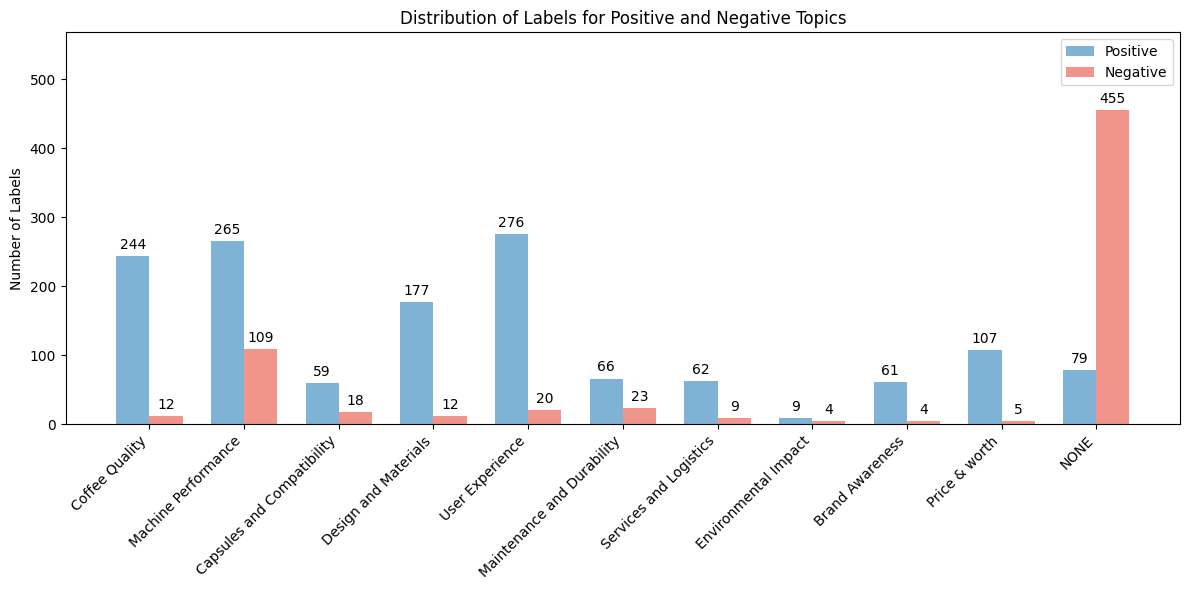

In [ ]:
def plot_topic_distribution(test_df, positive_column, negative_column, categories, title):
    """
    This function plots the distribution of positive and negative topic labels.

    Parameters:
    - test_df: DataFrame containing the topic classifications
    - positive_column: The column name for positive topic classifications
    - negative_column: The column name for negative topic classifications
    - categories: List of all possible topic categories
    """

    # Initialize the counts for positive and negative topics
    positive_counts = {category: 0 for category in categories}
    negative_counts = {category: 0 for category in categories}

    # Loop through each row in the DataFrame
    for _, row in test_df.iterrows():
        # Increment counts for positive topics
        for category in row[positive_column].split(', '):
            if category in positive_counts:
                positive_counts[category] += 1

        # Increment counts for negative topics
        for category in row[negative_column].split(', '):
            if category in negative_counts:
                negative_counts[category] += 1

    # Prepare the data for plotting
    positive_counts_values = [positive_counts[cat] for cat in categories]
    negative_counts_values = [negative_counts[cat] for cat in categories]

    x = range(len(categories))
    width = 0.35

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x, positive_counts_values, width, label='Positive', color='#7FB3D5')
    rects2 = ax.bar([i + width for i in x], negative_counts_values, width, label='Negative', color='#F1948A')

    ax.set_ylabel('Number of Labels')
    ax.set_title(title)
    plt.xticks([i + width / 2 for i in x], categories, rotation=45, ha="right")
    ax.legend()

    # Adding annotations with condition for 0 values
    for rect in rects1 + rects2:
        height = rect.get_height()
        annotation_text = f"{int(height)}" if height != 0 else "0"  # Show "0" for exact 0 values
        ax.annotate(annotation_text,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom")

    # Set custom y-axis limits
    max_value = max(max(positive_counts_values), max(negative_counts_values))
    ax.set_ylim(0, max_value + int(max_value * 0.25))

    plt.tight_layout()
    plt.show()

# Example of usage with test data
# Replace `test_df` with your actual DataFrame and categories list
categories = [
    "Coffee Quality", "Machine Performance", "Capsules and Compatibility",
    "Design and Materials", "User Experience", "Maintenance and Durability",
    "Services and Logistics", "Environmental Impact", "Brand Awareness",
    "Price & worth", "NONE"
]

plot_topic_distribution(test_df, 'positiveTopicClass', 'negativeTopicClass', categories, title="Distribution of Labels for Positive and Negative Topics")

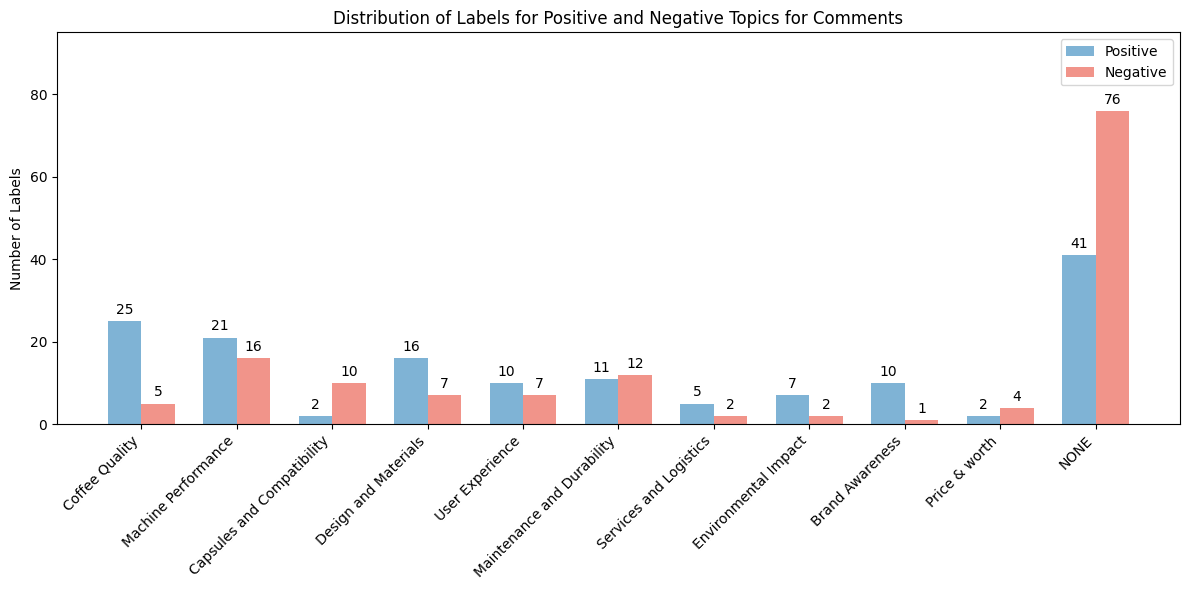

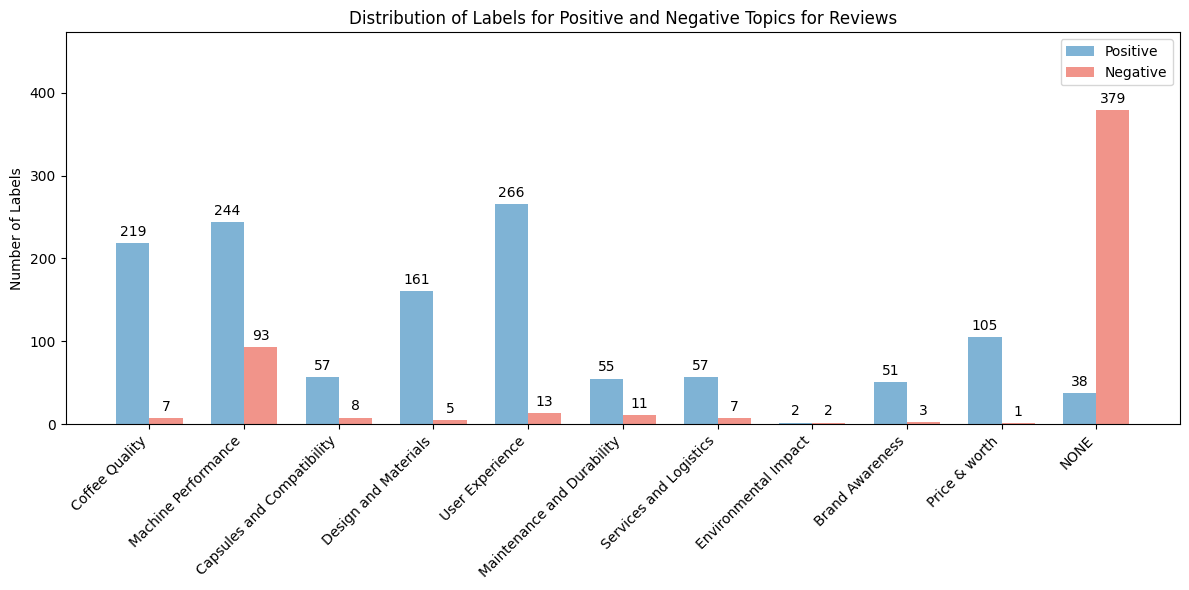

In [ ]:
plot_topic_distribution(test_comments_df, 'positiveTopicClass', 'negativeTopicClass', categories, title = "Distribution of Labels for Positive and Negative Topics for Comments")
plot_topic_distribution(test_reviews_df, 'positiveTopicClass', 'negativeTopicClass', categories, title = "Distribution of Labels for Positive and Negative Topics for Reviews")

In [19]:

def compute_metrics(true_labels, pred_labels):

  categories = [
      "Coffee Quality", "Machine Performance", "Capsules and Compatibility",
      "Design and Materials", "User Experience", "Maintenance and Durability",
      "Services and Logistics", "Environmental Impact", "Brand Awareness",
      "Price & worth", "NONE"
  ]
  # Funzione per convertire in formato binario per ciascun esempio
  def encode_labels(labels, categories):
      return [1 if category in labels else 0 for category in categories]

  # Inizializziamo le liste per le etichette positive e negative
  true_pos_labels = []
  pred_pos_labels = []
  true_neg_labels = []
  pred_neg_labels = []

  # Codifica le etichette true e predicted per ogni esempio
  for true, pred in zip(true_labels, pred_labels):
      true_pos = encode_labels(true["positiveTopicClass"], categories)
      pred_pos = encode_labels(pred["positiveTopicClass"], categories)
      true_neg = encode_labels(true["negativeTopicClass"], categories)
      pred_neg = encode_labels(pred["negativeTopicClass"], categories)

      true_pos_labels.append(true_pos)
      pred_pos_labels.append(pred_pos)
      true_neg_labels.append(true_neg)
      pred_neg_labels.append(pred_neg)

  # Calcoliamo la precisione, recall e F1-score per le etichette positive e negative separatamente
  precision_pos = precision_score(true_pos_labels, pred_pos_labels, average='weighted', zero_division=0)
  recall_pos = recall_score(true_pos_labels, pred_pos_labels, average='weighted', zero_division=0)
  f1_pos = f1_score(true_pos_labels, pred_pos_labels, average='weighted', zero_division=0)

  precision_neg = precision_score(true_neg_labels, pred_neg_labels, average='weighted', zero_division=0)
  recall_neg = recall_score(true_neg_labels, pred_neg_labels, average='weighted', zero_division=0)
  f1_neg = f1_score(true_neg_labels, pred_neg_labels, average='weighted', zero_division=0)

  pprint({
      'Precision (Positive - Weighted)': precision_pos,
      'Recall (Positive - Weighted)': recall_pos,
      'F1 (Positive - Weighted)': f1_pos,
      'Precision (Negative - Weighted)': precision_neg,
      'Recall (Negative - Weighted)': recall_neg,
      'F1 (Negative - Weighted)': f1_neg,
  })

In [20]:
# Multi Topic Sentiment Classification Test Function
def test(model, tokenizer, test_df, task=None, system_prompt=None, examples=None, batch_size=1, output_csv="responses.csv"):

    comments = list(test_df['text'])
    true_labels = test_df.apply(
        lambda row: {
            "positiveTopicClass": row["positiveTopicClass"].split(', '),
            "negativeTopicClass": row["negativeTopicClass"].split(', '),
        },
        axis=1
    ).tolist()

    # Shuffle comments and labels together
    combined = list(zip(comments, true_labels))
    random.shuffle(combined)
    comments, true_labels = zip(*combined)

    # Predictions
    pred_labels = []

    # Open CSV file for writing with tab separator
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=["comment", "positiveTopicClass", "negativeTopicClass", "primaryPositiveAspect", "primaryNegativeAspect"], delimiter='\t')
        writer.writeheader()  # Write CSV header

        # Process the comments in batches
        for i in tqdm(range(0, len(comments), batch_size), total=(len(comments) // batch_size) + (len(comments) % batch_size > 0), desc="TEST: Multi Topic Sentiment Classification"):
            batch_comments = comments[i : i + batch_size]
            batch_labels = true_labels[i : i + batch_size]  # True labels for this batch

            # Generate the predicted labels for the current batch
            prompt = build_prompt(task, system_prompt, examples, batch_comments, tokenizer)
            response = generate_response(task, prompt, n_feedbacks=len(batch_labels)+1)[1:]

            # Save responses to CSV
            for comment, elem in zip(batch_comments, response):
                # Sanitize the topic class fields to remove stray brackets or extra characters
                positive_topics = [topic.strip('[]').strip() for topic in elem.get('positiveTopicClass', [])]
                negative_topics = [topic.strip('[]').strip() for topic in elem.get('negativeTopicClass', [])]

                row = {
                    "comment": comment,
                    "positiveTopicClass": ", ".join(positive_topics),
                    "negativeTopicClass": ", ".join(negative_topics),
                    "primaryPositiveAspect": elem.get('primaryPositiveAspect', 'NONE'),
                    "primaryNegativeAspect": elem.get('primaryNegativeAspect', 'NONE')
                }
                writer.writerow(row)

            # Pick only positiveTopicClass and negativeTopicClass
            pred = [{'positiveTopicClass': elem['positiveTopicClass'], 'negativeTopicClass': elem['negativeTopicClass']} for elem in response]
            pred_labels.extend(pred)

            # Free the GPU
            del batch_comments
            del batch_labels
            del prompt
            del response
            gc.collect()
            torch.cuda.empty_cache()

    # Calculate and print performance metrics
    compute_metrics(true_labels, pred_labels)


### Gemma2-9B-it

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "google/gemma-2-9b-it"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Model memory footprint: 18.48 GB


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Vocabulary size of tokenizer: 256000


In [ ]:
# Gemma 0-shot
print("Gemma 0-shot")
test(model, tokenizer, test_df, task='multitopic_sentiment_classification', system_prompt=system_prompt, examples=None, batch_size=5, output_csv="gemma_zeroshot.csv")

In [ ]:
"""{'F1 (Negative - Weighted)': 0.895205464202892,
 'F1 (Positive - Weighted)': 0.7321681337377822,
 'Precision (Negative - Weighted)': 0.9014545212314731,
 'Precision (Positive - Weighted)': 0.8342056254975715,
 'Recall (Negative - Weighted)': 0.9001490312965723,
 'Recall (Positive - Weighted)': 0.7053380782918149}"""

In [ ]:
# Gemma Few-shot
print("Gemma Few-shot")
test(model, tokenizer, test_df, task='multitopic_sentiment_classification', system_prompt=system_prompt, examples=examples, batch_size=5, output_csv="gemma_fewshot.csv")

In [ ]:
"""{'F1 (Negative - Weighted)': 0.8998538962572653,
 'F1 (Positive - Weighted)': 0.7322346247949033,
 'Precision (Negative - Weighted)': 0.9055966515388033,
 'Precision (Positive - Weighted)': 0.8442725548290185,
 'Recall (Negative - Weighted)': 0.9046199701937406,
 'Recall (Positive - Weighted)': 0.693950177935943}"""

### Llama3.1-8B-it

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model memory footprint: 16.06 GB


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Vocabulary size of tokenizer: 128000


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Llama 0-shot
print("Llama 0-shot")
test(model, tokenizer, test_df, task='multitopic_sentiment_classification', system_prompt=system_prompt, examples=None, batch_size=5, output_csv="llama_zeroshot.csv")

In [ ]:
"""{'F1 (Negative - Weighted)': 0.8805585031568159,
 'F1 (Positive - Weighted)': 0.7453092863727785,
 'Precision (Negative - Weighted)': 0.9015923472134277,
 'Precision (Positive - Weighted)': 0.7953070691716744,
 'Recall (Negative - Weighted)': 0.879284649776453,
 'Recall (Positive - Weighted)': 0.7188612099644128}"""

In [ ]:
# Llama Few-shot
print("Llama Few-shot")
test(model, tokenizer, test_df, task='multitopic_sentiment_classification', system_prompt=system_prompt, examples=examples, batch_size=5, output_csv="llama_fewshot.csv")

In [ ]:
"""{'F1 (Negative - Weighted)': 0.8783980729990318,
 'F1 (Positive - Weighted)': 0.7308106210943724,
 'Precision (Negative - Weighted)': 0.8954763021166222,
 'Precision (Positive - Weighted)': 0.8116881069996368,
 'Recall (Negative - Weighted)': 0.8748137108792846,
 'Recall (Positive - Weighted)': 0.693950177935943}"""

### Mistral-7B-it-v0.3

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model memory footprint: 14.50 GB


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Vocabulary size of tokenizer: 32768


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Mistral 0-shot
print("Mistral 0-shot")
test(model, tokenizer, test_df, task='multitopic_sentiment_classification', system_prompt=system_prompt, examples=None, batch_size=5, output_csv="mistral_zeroshot.csv")

In [ ]:
"""{'F1 (Negative - Weighted)': 0.8734647379350539,
 'F1 (Positive - Weighted)': 0.7382561322885596,
 'Precision (Negative - Weighted)': 0.8859113811616309,
 'Precision (Positive - Weighted)': 0.7618456305236286,
 'Recall (Negative - Weighted)': 0.8733233979135618,
 'Recall (Positive - Weighted)': 0.7352313167259786}"""

In [ ]:
# Mistral Few-shot
print("Mistral Few-shot")
test(model, tokenizer, test_df, task='multitopic_sentiment_classification', system_prompt=system_prompt, examples=examples, batch_size=5, output_csv="mistral_fewshot.csv")

In [ ]:
"""{'F1 (Negative - Weighted)': 0.8808171194763148,
 'F1 (Positive - Weighted)': 0.715786566640132,
 'Precision (Negative - Weighted)': 0.9049876535577789,
 'Precision (Positive - Weighted)': 0.7889675534256647,
 'Recall (Negative - Weighted)': 0.8733233979135618,
 'Recall (Positive - Weighted)': 0.6797153024911032}"""

## Inference Phase

In [9]:
#comments_df = pd.read_csv(data_folder+'relevant_comments.csv', sep='\t')
comments_df = pd.read_csv(output_folder+'relevant_comments.csv', sep='\t')
comments_df.isna().sum(), comments_df.shape

(text                0
 postUrl             0
 commentTimeStamp    0
 postCaption         0
 postTimeStamp       0
 model               0
 Media type          0
 isComment           0
 Source              0
 relevanceLabel      0
 dtype: int64,
 (43, 10))

In [10]:
reviews_df = pd.read_csv(data_folder+'reviews.csv', sep='\t')
reviews_df.isna().sum(), reviews_df.shape

(text                     0
 channel                  0
 feedbackRating           0
 reviewDate               0
 positiveTopicClass     325
 negativeTopicClass    2224
 model                    0
 dtype: int64,
 (2930, 7))

In [11]:
# Drop positiveTopicClass and negativeTopicClass since we are going to reassign
reviews_df.drop(columns=['positiveTopicClass', 'negativeTopicClass'], inplace=True)

In [12]:
# we consider only tinyeco feedbacks
comments_df = comments_df[comments_df.model == 'tinyeco'].reset_index(drop=True)
reviews_df = reviews_df[reviews_df.model == 'tinyeco'].reset_index(drop=True)

In [13]:
def multitopic_sentiment_classifier(model, tokenizer, df, task=None, system_prompt=None, examples=None, batch_size=5):

    # Extract reviews from the DataFrame
    feedbacks = df['text'].tolist()
    pred_labels = []

    # Process the comments in batches
    for i in tqdm(range(0, len(feedbacks), batch_size), total=(len(feedbacks) // batch_size) + (len(feedbacks) % batch_size > 0)):
        batch_feedbacks = feedbacks[i : i + batch_size]

        # Build the prompt and generate the response
        prompt = build_prompt(task, system_prompt, examples, batch_feedbacks, tokenizer)
        response = generate_response(task, prompt, n_feedbacks=len(batch_feedbacks)+1)[1:]
        pprint(response)
        # Append predictions
        pred_labels.extend(response)  # Collect predictions for the batch

        # Free the GPU
        del batch_feedbacks
        del prompt
        del response
        gc.collect()
        torch.cuda.empty_cache()

    # Add predictions as a new column in the DataFrame
    temp_df = pd.DataFrame(pred_labels)
    df["positiveTopicClass"] = temp_df["positiveTopicClass"].apply(lambda x: ', '.join(x))
    df["negativeTopicClass"] = temp_df["negativeTopicClass"].apply(lambda x: ', '.join(x))
    df["primaryPositiveAspect"] = temp_df["primaryPositiveAspect"]
    df["primaryNegativeAspect"] = temp_df["primaryNegativeAspect"]

    return df


In [ ]:
# Build best LLM and Tokenizer
MODEL_NAME = "google/gemma-2-9b-it"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

In [ ]:
# Classify Feedbacks
multitopic_sentiment_comments_df = multitopic_sentiment_classifier(model,
                                    tokenizer,
                                    comments_df.copy(),
                                    task='multitopic_sentiment_classification',
                                    system_prompt=system_prompt,
                                    examples=examples,
                                    batch_size=5)
multitopic_sentiment_comments_df.head()

In [ ]:
# Classify Feedbacks
multitopic_sentiment_reviews_df = multitopic_sentiment_classifier(model,
                                    tokenizer,
                                    reviews_df.copy(),
                                    task='multitopic_sentiment_classification',
                                    system_prompt=system_prompt,
                                    examples=examples,
                                    batch_size=5)
multitopic_sentiment_reviews_df.head()

In [ ]:
# Save the results
multitopic_sentiment_comments_df.to_csv(output_folder+'multitopic-relevant-comments.csv', sep='\t', index=False)
multitopic_sentiment_reviews_df.to_csv(output_folder+'multitopic-reviews.csv', sep='\t', index=False)

# Sentiment Classification & Star Rating

In [ ]:
# Sentiment Classification Prompt
sentiment_system_prompt = (
    "You are an AI assistant trained to analyze user comments related to coffee machines.\n"
    "Your task is to classify the overall sentiment of each comment as either 'Positive', 'Neutral', or 'Negative'.\n"
    "Base your classification on the tone, language, and content of the feedback.\n"
    "Output only the sentiment for each feedback without additional text.\n"
    "Make sure to consider phrases and keywords that indicate satisfaction, dissatisfaction, or neutrality when making your classification.\n"
)

# Sentiment Classification Examples
sentiment_examples = [
    ("The coffee machine works perfectly and looks great in my kitchen!", "Positive"),
    ("It's okay, but the water tank is too small for my needs.", "Neutral"),
    ("Terrible experience! The machine broke after two uses.", "Negative"),
    ("I love the flavor of the coffee, but it's a bit noisy.", "Positive"),
    ("The product is alright, but I wouldn't buy it again.", "Neutral"),
    ("Worst machine ever. Not worth the price.", "Negative"),
    ("This is the best coffee machine I've ever owned—worth every penny!", "Positive"),
    ("The brewing process takes forever, and the coffee isn't even hot enough.", "Negative"),
]

In [ ]:
# Sentiment Classification Prompt
star_system_prompt = (
    "You are an AI assistant trained to analyze user comments related to coffee machines.\n"
    "Your task is to classify the overall sentiment of each comment as either 'Positive', 'Neutral', or 'Negative'.\n"
    "Base your classification on the tone, language, and content of the feedback.\n"
    "Output only the sentiment for each feedback without additional text.\n"
    "Make sure to consider phrases and keywords that indicate satisfaction, dissatisfaction, or neutrality when making your classification.\n"
)

# Sentiment Classification Examples
star_examples = [
    ("The coffee machine works perfectly and looks great in my kitchen!", "Positive"),
    ("It's okay, but the water tank is too small for my needs.", "Neutral"),
    ("Terrible experience! The machine broke after two uses.", "Negative"),
    ("I love the flavor of the coffee, but it's a bit noisy.", "Positive"),
    ("The product is alright, but I wouldn't buy it again.", "Neutral"),
    ("Worst machine ever. Not worth the price.", "Negative"),
    ("This is the best coffee machine I've ever owned—worth every penny!", "Positive"),
    ("The brewing process takes forever, and the coffee isn't even hot enough.", "Negative"),
]


## Test Phase

In [4]:
# Load reviews X star rating
reviews_df = pd.read_csv(data_folder+'reviews.csv', sep='\t')
reviews_df.isna().sum(), reviews_df.shape

(text                     0
 channel                  0
 feedbackRating           0
 reviewDate               0
 positiveTopicClass     325
 negativeTopicClass    2224
 model                    0
 dtype: int64,
 (2930, 7))

In [5]:
review_test_df = reviews_df[['text', 'feedbackRating']].sample(n=500, random_state=42)
review_test_df.head()

,text,feedbackRating
1357,"Perfetta ! Excellent coffee, warm and creamy. ...",5.0
2367,Good A little noisy,4.0
2822,Coffee All good,5.0
2126,I needed it right away. The price is a little ...,4.0
1544,"Great car I already knew this machine, it make...",5.0


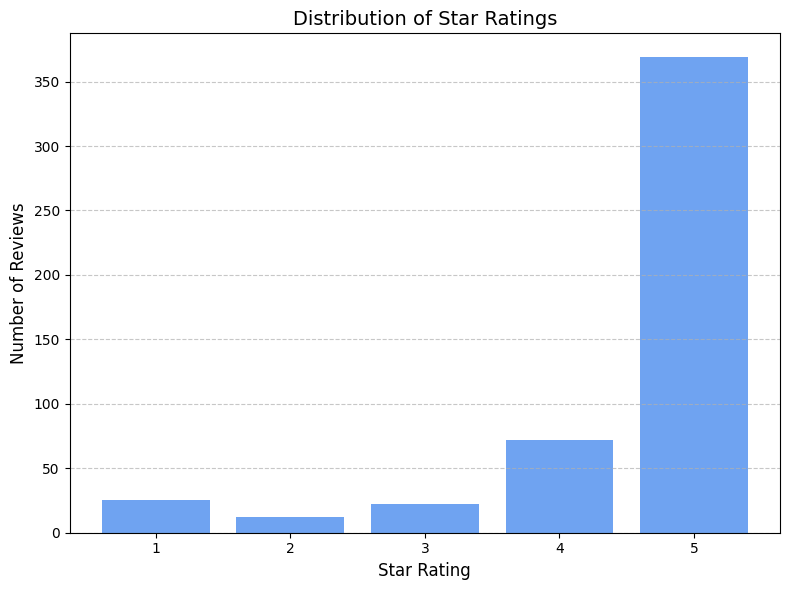

In [6]:
import matplotlib.pyplot as plt

# Get the rating counts
rating_counts = review_test_df['feedbackRating'].value_counts().sort_index()

# Set up the figure and axis
plt.figure(figsize=(8, 6))

# Plot the bar chart with a new color
plt.bar(rating_counts.index, rating_counts.values, color='#6fa3f1')

# Add labels and title
plt.xlabel("Star Rating", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.title("Distribution of Star Ratings", fontsize=14)

# Customize x-ticks to display all rating values
plt.xticks(rating_counts.index)

# Show gridlines only on the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Load synthetic comments X sentiment classification
synthetic_comments_df = pd.read_csv(data_folder+'synthetic-comments.csv', sep='\t')
synthetic_comments_df.isna().sum(), synthetic_comments_df.shape

(text                 0
 label                0
 topics              66
 positive_topics    146
 negative_topics    153
 sentiment            0
 dtype: int64,
 (236, 6))

In [ ]:
comments_test_df = synthetic_comments_df[['text', 'sentiment']]
comments_test_df.head()

,text,sentiment
0,I love color,Positive
1,I like color.Different from usual,Positive
2,Color :TOP_arrow:,Positive
3,BEAUTIFUL,Positive
4,Smiling_face_with_heart-Eyes :: Smiling_face_w...,Positive


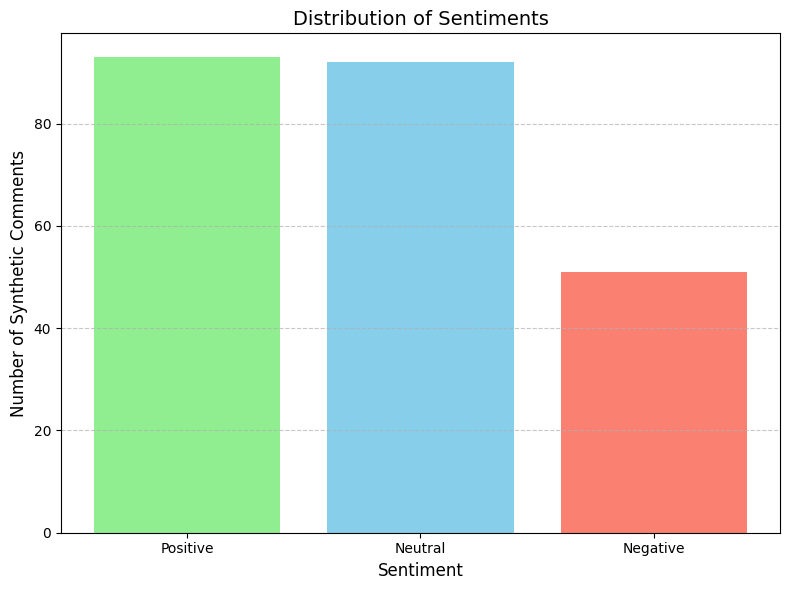

In [ ]:
# Calculate sentiment counts
sentiment_counts = comments_test_df['sentiment'].value_counts()

# Set up the figure and axis
plt.figure(figsize=(8, 6))

# Plot the bar chart with custom colors
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['lightgreen', 'skyblue', 'salmon'])

# Add labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Synthetic Comments", fontsize=12)
plt.title("Distribution of Sentiments", fontsize=14)

# Customize x-ticks to display sentiment labels properly
plt.xticks(sentiment_counts.index, rotation=0)

# Show gridlines only on the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for tight fit
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
### SENTIMENT CLASSIFICATION AND STAR RATING METRICS AND TEST FUNCTION
# they are the same since they are multi class classification

def compute_metrics(true_labels, pred_labels, task=None):
    """
    Compute and display metrics for classification tasks.
    """
    # Define class labels based on the task
    if task == "sentiment_classification":
        class_labels = [2, 1, 0]  # Positive, Neutral, Negative
        label_names = ["Positive", "Neutral", "Negative"]
    elif task == "star_rating":
        class_labels = [1, 2, 3, 4, 5]  # Star ratings 1 to 5
        label_names = [str(i) for i in class_labels]
    else:
        raise ValueError("Invalid task_type. Use 'sentiment_classification' or 'star_rating'.")

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    precision_macro = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall_macro = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1_macro = f1_score(true_labels, pred_labels, average='macro', zero_division=0)

    # Off-by-One calculation for star rating
    off_by_one = None
    if task == "star_rating":
        off_by_one = sum([abs(t - p) <= 1 for t, p in zip(true_labels, pred_labels)]) / len(true_labels)

    # Metrics table
    metrics_table = [
        ["Accuracy", f"{accuracy:.3f}"],
        ["Weighted Precision", f"{precision:.3f}"],
        ["Weighted Recall", f"{recall:.3f}"],
        ["Weighted F1 Score", f"{f1:.3f}"],
        ["Macro Precision", f"{precision_macro:.3f}"],
        ["Macro Recall", f"{recall_macro:.3f}"],
        ["Macro F1 Score", f"{f1_macro:.3f}"]
    ]

    if off_by_one is not None:
        metrics_table.append(["Off-by-One", f"{off_by_one:.3f}"])

    print(tabulate(metrics_table, headers=["Metric", "Score"], tablefmt="grid"))
    print()

    # Confusion matrix with all class labels
    cm = confusion_matrix(true_labels, pred_labels, labels=class_labels)
    header = [f"Pred {name}" for name in label_names]
    cm_table = [[""] + header]
    for i, row in enumerate(cm):
        cm_table.append([f"True {label_names[i]}"] + list(row))

    print("Confusion Matrix:")
    print(tabulate(cm_table, headers="firstrow", tablefmt="grid"))
    print("\n" + "-" * 50)


# Product Relevance Classificatioin Test Function
def sentiment_classification_test(model, tokenizer, test_df, task=None, system_prompt=None, examples=None, batch_size=5):

    comments = list(test_df['text'])
    true_labels =  list(test_df['sentiment'])

    # Shuffle comments and labels together
    combined = list(zip(comments, true_labels))
    random.seed(42)
    random.shuffle(combined)
    comments, true_labels = zip(*combined)

    # Predictions
    pred_labels = []

    # Process the comments in batches
    for i in tqdm(range(0, len(comments), batch_size), total=(len(comments) // batch_size) + (len(comments) % batch_size > 0), desc="TEST: Overall Sentiment Classification"):
        batch_comments = comments[i : i + batch_size]
        batch_labels = true_labels[i : i + batch_size]  # True labels for this batch

        # Generate the predicted labels for the current batch
        prompt = build_prompt(task, system_prompt, examples, batch_comments, tokenizer)
        response = generate_response(task, prompt, n_feedbacks=len(batch_comments)+3)[3:]
        pred_labels.extend(response)

        # Free the GPU
        del batch_comments
        del batch_labels
        del prompt
        del response
        gc.collect()
        torch.cuda.empty_cache()

    # Map the labels
    sentiment_mapping = {
        'Negative': 0,
        'Neutral': 1,
        'Positive': 2
    }
    true_labels = [sentiment_mapping[label] for label in true_labels]
    pred_labels = [sentiment_mapping[label] for label in pred_labels]


    # Calculate and print performance metrics
    compute_metrics(true_labels, pred_labels, task='sentiment_classification')




# Product Relevance Classificatioin Test Function
def star_rating_test(model, tokenizer, test_df, task=None, system_prompt=None, examples=None, batch_size=5):

    comments = list(test_df['text'])
    true_labels =  list(test_df['feedbackRating'])

    # Shuffle comments and labels together
    combined = list(zip(comments, true_labels))
    random.seed(42)
    random.shuffle(combined)
    comments, true_labels = zip(*combined)

    # Predictions
    pred_labels = []

    # Process the comments in batches
    for i in tqdm(range(0, len(comments), batch_size), total=(len(comments) // batch_size) + (len(comments) % batch_size > 0), desc="TEST: Star Rating"):
        batch_comments = comments[i : i + batch_size]
        batch_labels = true_labels[i : i + batch_size]  # True labels for this batch

        # Generate the predicted labels for the current batch
        prompt = build_prompt(task, system_prompt, examples, batch_comments, tokenizer)
        response = generate_response(task, prompt, n_feedbacks=len(batch_comments)+3)[3:]
        pred_labels.extend(response)

        # Free the GPU
        del batch_comments
        del batch_labels
        del prompt
        del response
        gc.collect()
        torch.cuda.empty_cache()

    # Map the labels
    true_labels = [int(label) for label in true_labels]
    pred_labels = [int(label) for label in pred_labels]


    # Calculate and print performance metrics
    compute_metrics(true_labels, pred_labels, task='star_rating')

### Gemma2-9B-it

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "google/gemma-2-9b-it"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

In [ ]:
# Sentiment Classification - Gemma 0-shot
print("Sentiment Classification - Gemma 0-shot")
sentiment_classification_test(model, tokenizer, comments_test_df, task='sentiment_classification', system_prompt=sentiment_system_prompt, examples=None, batch_size=20)

In [ ]:
"""Sentiment Classification - Gemma 0-shot
TEST: Overall Sentiment Classification:   0%|          | 0/12 [00:00<?, ?it/s]The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
TEST: Overall Sentiment Classification: 100%|██████████| 12/12 [14:47<00:00, 74.00s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.869 |
+--------------------+---------+
| Weighted Precision |   0.878 |
+--------------------+---------+
| Weighted Recall    |   0.869 |
+--------------------+---------+
| Weighted F1 Score  |   0.866 |
+--------------------+---------+
| Macro Precision    |   0.866 |
+--------------------+---------+
| Macro Recall       |   0.876 |
+--------------------+---------+
| Macro F1 Score     |   0.864 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              90 |              1 |               2 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              14 |             68 |              10 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               1 |              3 |              47 |
+---------------+-----------------+----------------+-----------------+"""

In [ ]:
# Sentiment Classification - Gemma Few-shot
print("Sentiment Classification - Gemma Few-shot")
sentiment_classification_test(model, tokenizer, comments_test_df, task='sentiment_classification', system_prompt=sentiment_system_prompt, examples=sentiment_examples, batch_size=20)

In [ ]:
"""Sentiment Classification - Gemma Few-shot
TEST: Overall Sentiment Classification: 100%|██████████| 12/12 [15:33<00:00, 77.79s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.852 |
+--------------------+---------+
| Weighted Precision |   0.856 |
+--------------------+---------+
| Weighted Recall    |   0.852 |
+--------------------+---------+
| Weighted F1 Score  |   0.849 |
+--------------------+---------+
| Macro Precision    |   0.847 |
+--------------------+---------+
| Macro Recall       |   0.853 |
+--------------------+---------+
| Macro F1 Score     |   0.846 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              89 |              3 |               1 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              14 |             68 |              10 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               2 |              5 |              44 |
+---------------+-----------------+----------------+-----------------+"""

In [ ]:
# Star Rating - Gemma 0-shot
print("Star Rating - Gemma 0-shot")
star_rating_test(model, tokenizer, review_test_df, task='star_rating', system_prompt=star_system_prompt, examples=None, batch_size=20)

In [ ]:
"""Star Rating - Gemma 0-shot
TEST: Star Rating: 100%|██████████| 25/25 [1:07:17<00:00, 161.49s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.596 |
+--------------------+---------+
| Weighted Precision |   0.763 |
+--------------------+---------+
| Weighted Recall    |   0.596 |
+--------------------+---------+
| Weighted F1 Score  |   0.65  |
+--------------------+---------+
| Macro Precision    |   0.486 |
+--------------------+---------+
| Macro Recall       |   0.556 |
+--------------------+---------+
| Macro F1 Score     |   0.477 |
+--------------------+---------+
| Off-by-One         |   0.908 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |       15 |        6 |        1 |        2 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 2 |        1 |        7 |        3 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 3 |        0 |        5 |       12 |        5 |        0 |
+--------+----------+----------+----------+----------+----------+
| True 4 |        0 |        4 |       18 |       30 |       20 |
+--------+----------+----------+----------+----------+----------+
| True 5 |        2 |        3 |       32 |       98 |      234 |
+--------+----------+----------+----------+----------+----------+"""

In [ ]:
# Star Rating - Gemma Few-shot
print("Star Rating - Gemma Few-shot")
star_rating_test(model, tokenizer, review_test_df, task='star_rating', system_prompt=star_system_prompt, examples=star_examples, batch_size=20)

In [ ]:
"""Star Rating - Gemma Few-shot
TEST: Star Rating: 100%|██████████| 25/25 [1:08:05<00:00, 163.43s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.592 |
+--------------------+---------+
| Weighted Precision |   0.765 |
+--------------------+---------+
| Weighted Recall    |   0.592 |
+--------------------+---------+
| Weighted F1 Score  |   0.647 |
+--------------------+---------+
| Macro Precision    |   0.482 |
+--------------------+---------+
| Macro Recall       |   0.548 |
+--------------------+---------+
| Macro F1 Score     |   0.468 |
+--------------------+---------+
| Off-by-One         |   0.908 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |       15 |        6 |        2 |        1 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 2 |        1 |        5 |        5 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 3 |        0 |        5 |       15 |        2 |        0 |
+--------+----------+----------+----------+----------+----------+
| True 4 |        0 |        2 |       21 |       30 |       19 |
+--------+----------+----------+----------+----------+----------+
| True 5 |        2 |        3 |       34 |       99 |      231 |
+--------+----------+----------+----------+----------+----------+"""

### Llama3.1-8B-it

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Sentiment Classification - Llama 0-shot
print("Sentiment Classification - Llama 0-shot")
sentiment_classification_test(model, tokenizer, comments_test_df, task='sentiment_classification', system_prompt=sentiment_system_prompt, examples=None, batch_size=20)

In [ ]:
"""Sentiment Classification - Llama 0-shot
TEST: Overall Sentiment Classification: 100%|██████████| 12/12 [10:53<00:00, 54.46s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.818 |
+--------------------+---------+
| Weighted Precision |   0.818 |
+--------------------+---------+
| Weighted Recall    |   0.818 |
+--------------------+---------+
| Weighted F1 Score  |   0.815 |
+--------------------+---------+
| Macro Precision    |   0.821 |
+--------------------+---------+
| Macro Recall       |   0.807 |
+--------------------+---------+
| Macro F1 Score     |   0.811 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              88 |              5 |               0 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              18 |             67 |               7 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               1 |             12 |              38 |
+---------------+-----------------+----------------+-----------------+"""

In [ ]:
# Sentiment Classification - Llama Few-shot
print("Sentiment Classification - Llama Few-shot")
sentiment_classification_test(model, tokenizer, comments_test_df, task='sentiment_classification', system_prompt=sentiment_system_prompt, examples=sentiment_examples, batch_size=20)

In [ ]:
"""Sentiment Classification - Llama Few-shot
TEST: Overall Sentiment Classification: 100%|██████████| 12/12 [11:39<00:00, 58.32s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.814 |
+--------------------+---------+
| Weighted Precision |   0.825 |
+--------------------+---------+
| Weighted Recall    |   0.814 |
+--------------------+---------+
| Weighted F1 Score  |   0.812 |
+--------------------+---------+
| Macro Precision    |   0.847 |
+--------------------+---------+
| Macro Recall       |   0.791 |
+--------------------+---------+
| Macro F1 Score     |   0.808 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              86 |              7 |               0 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              19 |             72 |               1 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               1 |             16 |              34 |
+---------------+-----------------+----------------+-----------------+"""

In [ ]:
# Star Rating - Llama 0-shot
print("Star Rating - Llama 0-shot")
star_rating_test(model, tokenizer, review_test_df, task='star_rating', system_prompt=star_system_prompt, examples=None, batch_size=20)

In [ ]:
"""Star Rating - Llama 0-shot
TEST: Star Rating: 100%|██████████| 25/25 [47:46<00:00, 114.66s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.682 |
+--------------------+---------+
| Weighted Precision |   0.764 |
+--------------------+---------+
| Weighted Recall    |   0.682 |
+--------------------+---------+
| Weighted F1 Score  |   0.713 |
+--------------------+---------+
| Macro Precision    |   0.499 |
+--------------------+---------+
| Macro Recall       |   0.587 |
+--------------------+---------+
| Macro F1 Score     |   0.528 |
+--------------------+---------+
| Off-by-One         |   0.948 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |       19 |        2 |        1 |        1 |        2 |
+--------+----------+----------+----------+----------+----------+
| True 2 |        3 |        6 |        2 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 3 |        1 |        5 |       11 |        5 |        0 |
+--------+----------+----------+----------+----------+----------+
| True 4 |        1 |        2 |       13 |       31 |       25 |
+--------+----------+----------+----------+----------+----------+
| True 5 |        3 |        4 |       10 |       78 |      274 |
+--------+----------+----------+----------+----------+----------+"""

In [ ]:
# Star Rating - Llama Few-shot
print("Star Rating - Llama Few-shot")
star_rating_test(model, tokenizer, review_test_df, task='star_rating', system_prompt=star_system_prompt, examples=star_examples, batch_size=20)

In [ ]:
"""Star Rating - Llama Few-shot
TEST: Star Rating: 100%|██████████| 25/25 [49:24<00:00, 118.59s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.682 |
+--------------------+---------+
| Weighted Precision |   0.777 |
+--------------------+---------+
| Weighted Recall    |   0.682 |
+--------------------+---------+
| Weighted F1 Score  |   0.715 |
+--------------------+---------+
| Macro Precision    |   0.53  |
+--------------------+---------+
| Macro Recall       |   0.62  |
+--------------------+---------+
| Macro F1 Score     |   0.55  |
+--------------------+---------+
| Off-by-One         |   0.942 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |       16 |        5 |        1 |        2 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 2 |        1 |        8 |        2 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 3 |        0 |        4 |       13 |        5 |        0 |
+--------+----------+----------+----------+----------+----------+
| True 4 |        1 |        1 |       13 |       34 |       23 |
+--------+----------+----------+----------+----------+----------+
| True 5 |        3 |        2 |       17 |       77 |      270 |
+--------+----------+----------+----------+----------+----------+"""

### Mistral-7B-it-v0.3

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
# Build LLM and Tokenizer
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
model, tokenizer = build_LLM(MODEL_NAME, HF_TOKEN)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Sentiment Classification - Mistral 0-shot
print("Sentiment Classification - Mistral 0-shot")
sentiment_classification_test(model, tokenizer, comments_test_df, task='sentiment_classification', system_prompt=sentiment_system_prompt, examples=None, batch_size=20)

In [ ]:
"""Sentiment Classification - Mistral 0-shot
TEST: Overall Sentiment Classification:  58%|█████▊    | 7/12 [07:46<05:33, 66.67s/it]Output does not match expected feedback count. Expected 23, but got 22. Retrying...
Output does not match expected feedback count. Expected 23, but got 22. Retrying...
Output does not match expected feedback count. Expected 23, but got 22. Retrying...
Output does not match expected feedback count. Expected 23, but got 22. Retrying...
TEST: Overall Sentiment Classification: 100%|██████████| 12/12 [18:42<00:00, 93.51s/it] +--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.877 |
+--------------------+---------+
| Weighted Precision |   0.88  |
+--------------------+---------+
| Weighted Recall    |   0.877 |
+--------------------+---------+
| Weighted F1 Score  |   0.876 |
+--------------------+---------+
| Macro Precision    |   0.871 |
+--------------------+---------+
| Macro Recall       |   0.881 |
+--------------------+---------+
| Macro F1 Score     |   0.873 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              89 |              3 |               1 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              11 |             72 |               9 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               1 |              4 |              46 |
+---------------+-----------------+----------------+-----------------+"""

In [ ]:
# Sentiment Classification - Mistral Few-shot
print("Sentiment Classification - Mistral Few-shot")
sentiment_classification_test(model, tokenizer, comments_test_df, task='sentiment_classification', system_prompt=sentiment_system_prompt, examples=sentiment_examples, batch_size=20)

In [ ]:
"""Sentiment Classification - Mistral Few-shot
TEST: Overall Sentiment Classification: 100%|██████████| 12/12 [14:34<00:00, 72.88s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.86  |
+--------------------+---------+
| Weighted Precision |   0.86  |
+--------------------+---------+
| Weighted Recall    |   0.86  |
+--------------------+---------+
| Weighted F1 Score  |   0.859 |
+--------------------+---------+
| Macro Precision    |   0.861 |
+--------------------+---------+
| Macro Recall       |   0.849 |
+--------------------+---------+
| Macro F1 Score     |   0.854 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              86 |              6 |               1 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              10 |             77 |               5 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               1 |             10 |              40 |
+---------------+-----------------+----------------+-----------------+"""

In [ ]:
# Star Rating - Mistral 0-shot
print("Star Rating - Mistral 0-shot")
star_rating_test(model, tokenizer, review_test_df, task='star_rating', system_prompt=star_system_prompt, examples=None, batch_size=20)

In [ ]:
"""Star Rating - Mistral 0-shot
TEST: Star Rating: 100%|██████████| 25/25 [51:02<00:00, 122.51s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.498 |
+--------------------+---------+
| Weighted Precision |   0.741 |
+--------------------+---------+
| Weighted Recall    |   0.498 |
+--------------------+---------+
| Weighted F1 Score  |   0.567 |
+--------------------+---------+
| Macro Precision    |   0.414 |
+--------------------+---------+
| Macro Recall       |   0.449 |
+--------------------+---------+
| Macro F1 Score     |   0.365 |
+--------------------+---------+
| Off-by-One         |   0.912 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |        8 |       13 |        3 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 2 |        1 |        7 |        3 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 3 |        1 |        6 |        9 |        6 |        0 |
+--------+----------+----------+----------+----------+----------+
| True 4 |        0 |        2 |       24 |       29 |       17 |
+--------+----------+----------+----------+----------+----------+
| True 5 |        2 |       12 |       22 |      137 |      196 |
+--------+----------+----------+----------+----------+----------+"""

In [ ]:
# Star Rating - Mistral Few-shot
print("Star Rating - Mistral Few-shot")
star_rating_test(model, tokenizer, review_test_df, task='star_rating', system_prompt=star_system_prompt, examples=star_examples, batch_size=20)

In [ ]:
"""Star Rating - Mistral Few-shot
TEST: Star Rating: 100%|██████████| 25/25 [53:46<00:00, 129.05s/it]+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.434 |
+--------------------+---------+
| Weighted Precision |   0.732 |
+--------------------+---------+
| Weighted Recall    |   0.434 |
+--------------------+---------+
| Weighted F1 Score  |   0.51  |
+--------------------+---------+
| Macro Precision    |   0.439 |
+--------------------+---------+
| Macro Recall       |   0.418 |
+--------------------+---------+
| Macro F1 Score     |   0.335 |
+--------------------+---------+
| Off-by-One         |   0.902 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |        7 |       13 |        4 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 2 |        0 |        7 |        4 |        0 |        1 |
+--------+----------+----------+----------+----------+----------+
| True 3 |        0 |        8 |        9 |        5 |        0 |
+--------+----------+----------+----------+----------+----------+
| True 4 |        0 |        4 |       24 |       26 |       18 |
+--------+----------+----------+----------+----------+----------+
| True 5 |        1 |       13 |       25 |      162 |      168 |
+--------+----------+----------+----------+----------+----------+"""

### Task Based Sentiment Classification Models

#### 1) DistilBert

In [ ]:
def sentiment_classification_test_with_bert(model, tokenizer, test_df, batch_size=50):
    comments = list(test_df['text'])
    true_labels = list(test_df['sentiment'])

    pred_labels = []

    # Measure execution time
    start_time = time.time()

    # Divide comments into batches
    for i in range(0, len(comments), batch_size):
        batch_comments = comments[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_comments, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate the response
        with torch.no_grad():  # Disable gradient computation
            # Generate the response
            outputs = model(**inputs)
            sentiment_scores = outputs.logits

        # Free memory
        del inputs
        gc.collect()
        torch.cuda.empty_cache()

        # Map scores to predicted labels
        pred_labels.extend((torch.argmax(sentiment_scores, dim=1)).tolist())

    # Calculate and print execution time
    end_time = time.time()
    execution_time_ms = (end_time - start_time) * 1000
    print(f"Execution Time: {execution_time_ms:.2f} ms\n")

    sentiment_mapping = {'Negative': 0,'Neutral': 1,'Positive': 2}
    score_mapping = {0:2, 1:1, 2:0} # use only with distilbert

    true_labels = [sentiment_mapping[label] for label in true_labels]
    pred_labels = [score_mapping[label] for label in pred_labels]

    compute_metrics(true_labels, pred_labels, task='sentiment_classification')

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
MODEL_NAME = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to("cuda")

In [ ]:
sentiment_classification_test_with_bert(model, tokenizer, synthetic_comments_df)

In [ ]:
"""Execution Time: 1540.14 ms

+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.496 |
+--------------------+---------+
| Weighted Precision |   0.436 |
+--------------------+---------+
| Weighted Recall    |   0.496 |
+--------------------+---------+
| Weighted F1 Score  |   0.388 |
+--------------------+---------+
| Macro Precision    |   0.448 |
+--------------------+---------+
| Macro Recall       |   0.511 |
+--------------------+---------+
| Macro F1 Score     |   0.413 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              84 |              1 |               8 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              69 |              2 |              21 |
+---------------+-----------------+----------------+-----------------+
| True Negative |              17 |              3 |              31 |
+---------------+-----------------+----------------+-----------------+"""

#### 2) Twitter RoBerta finetuned

In [ ]:
def sentiment_classification_test_with_bert(model, tokenizer, test_df, batch_size=50):
    comments = list(test_df['text'])
    true_labels = list(test_df['sentiment'])

    pred_labels = []

    # Measure execution time
    start_time = time.time()

    # Divide comments into batches
    for i in range(0, len(comments), batch_size):
        batch_comments = comments[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_comments, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate the response
        with torch.no_grad():  # Disable gradient computation
            # Generate the response
            outputs = model(**inputs)
            sentiment_scores = outputs.logits

        # Free memory
        del inputs
        gc.collect()
        torch.cuda.empty_cache()

        # Map scores to predicted labels
        pred_labels.extend((torch.argmax(sentiment_scores, dim=1)).tolist())

    # Calculate and print execution time
    end_time = time.time()
    execution_time_ms = (end_time - start_time) * 1000
    print(f"Execution Time: {execution_time_ms:.2f} ms\n")

    sentiment_mapping = {'Negative': 0,'Neutral': 1,'Positive': 2}
    #score_mapping = {0:2, 1:1, 2:0}

    true_labels = [sentiment_mapping[label] for label in true_labels]
    #pred_labels = [score_mapping[label] for label in pred_labels]

    compute_metrics(true_labels, pred_labels, task='sentiment_classification')

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
MODEL_NAME = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to("cuda")

In [ ]:
sentiment_classification_test_with_bert(model, tokenizer, synthetic_comments_df)

In [ ]:
"""Execution Time: 1599.26 ms

+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.682 |
+--------------------+---------+
| Weighted Precision |   0.751 |
+--------------------+---------+
| Weighted Recall    |   0.682 |
+--------------------+---------+
| Weighted F1 Score  |   0.68  |
+--------------------+---------+
| Macro Precision    |   0.772 |
+--------------------+---------+
| Macro Recall       |   0.657 |
+--------------------+---------+
| Macro F1 Score     |   0.675 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              53 |             38 |               2 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |               9 |             82 |               1 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               0 |             25 |              26 |
+---------------+-----------------+----------------+-----------------+"""

#### 3) Twitter RoBerta latest

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
from transformers import logging
logging.set_verbosity_error()
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to("cuda")

In [ ]:
sentiment_classification_test_with_bert(model, tokenizer, synthetic_comments_df)

In [ ]:
"""Execution Time: 1985.68 ms

+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.831 |
+--------------------+---------+
| Weighted Precision |   0.837 |
+--------------------+---------+
| Weighted Recall    |   0.831 |
+--------------------+---------+
| Weighted F1 Score  |   0.829 |
+--------------------+---------+
| Macro Precision    |   0.854 |
+--------------------+---------+
| Macro Recall       |   0.82  |
+--------------------+---------+
| Macro F1 Score     |   0.832 |
+--------------------+---------+

Confusion Matrix:
+---------------+-----------------+----------------+-----------------+
|               |   Pred Positive |   Pred Neutral |   Pred Negative |
+===============+=================+================+=================+
| True Positive |              87 |              5 |               1 |
+---------------+-----------------+----------------+-----------------+
| True Neutral  |              21 |             70 |               1 |
+---------------+-----------------+----------------+-----------------+
| True Negative |               0 |             12 |              39 |
+---------------+-----------------+----------------+-----------------+"""

### Task Based Star Rating Classification Models

#### 1) Bert base

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to("cuda")

In [ ]:
def star_rating_test_with_bert(model, tokenizer, test_df, batch_size=50):
    comments = list(test_df['text'])
    true_labels = list(test_df['feedbackRating'])

    pred_labels = []

    # Measure execution time
    start_time = time.time()

    # Divide comments into batches
    for i in range(0, len(comments), batch_size):
        batch_comments = comments[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_comments, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate the response
        with torch.no_grad():  # Disable gradient computation
            # Generate the response
            outputs = model(**inputs)
            rating_scores = outputs.logits

        # Free memory
        del inputs
        gc.collect()
        torch.cuda.empty_cache()

        # Map scores to predicted labels
        pred_labels.extend((torch.argmax(rating_scores, dim=1) + 1).tolist())

    # Calculate and print execution time
    end_time = time.time()
    execution_time_ms = (end_time - start_time) * 1000
    print(f"Execution Time: {execution_time_ms:.2f} ms\n")

    true_labels = [int(label) for label in true_labels]
    pred_labels = [int(label) for label in pred_labels]

    compute_metrics(true_labels, pred_labels, task='star_rating')

In [ ]:
star_rating_test_with_bert(model, tokenizer, reviews_df)

In [ ]:
"""Execution Time: 53961.19 ms

+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.692 |
+--------------------+---------+
| Weighted Precision |   0.757 |
+--------------------+---------+
| Weighted Recall    |   0.692 |
+--------------------+---------+
| Weighted F1 Score  |   0.718 |
+--------------------+---------+
| Macro Precision    |   0.479 |
+--------------------+---------+
| Macro Recall       |   0.54  |
+--------------------+---------+
| Macro F1 Score     |   0.499 |
+--------------------+---------+
| Off-by-One         |   0.955 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |      109 |       35 |        6 |        0 |        5 |
+--------+----------+----------+----------+----------+----------+
| True 2 |       23 |       30 |       17 |        3 |        2 |
+--------+----------+----------+----------+----------+----------+
| True 3 |       11 |       35 |       46 |       31 |        6 |
+--------+----------+----------+----------+----------+----------+
| True 4 |        6 |        6 |       64 |      210 |      162 |
+--------+----------+----------+----------+----------+----------+
| True 5 |       11 |       16 |       61 |      401 |     1634 |
+--------+----------+----------+----------+----------+----------+"""

#### 2) Multilingual-sentiment

In [ ]:
try:
  del model
  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass

In [ ]:
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda")

In [ ]:
def star_rating_test_with_bert(model, tokenizer, test_df, batch_size=50):
    comments = list(test_df['text'])
    true_labels = list(test_df['feedbackRating'])

    pred_labels = []

    # Measure execution time
    start_time = time.time()

    # Divide comments into batches
    for i in range(0, len(comments), batch_size):
        batch_comments = comments[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_comments, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Generate the response
        with torch.no_grad():  # Disable gradient computation
            # Generate the response
            outputs = model(**inputs)
            rating_scores = outputs.logits

        # Free memory
        del inputs
        gc.collect()
        torch.cuda.empty_cache()

        # Map scores to predicted labels
        pred_labels.extend((torch.argmax(rating_scores, dim=1) + 1).tolist())

    # Calculate and print execution time
    end_time = time.time()
    execution_time_ms = (end_time - start_time) * 1000
    print(f"Execution Time: {execution_time_ms:.2f} ms\n")

    true_labels = [int(label) for label in true_labels]
    pred_labels = [int(label) for label in pred_labels]

    compute_metrics(true_labels, pred_labels, task='star_rating')

In [ ]:
star_rating_test_with_bert(model, tokenizer, reviews_df)

In [ ]:
"""Execution Time: 30642.12 ms

+--------------------+---------+
| Metric             |   Score |
+====================+=========+
| Accuracy           |   0.552 |
+--------------------+---------+
| Weighted Precision |   0.706 |
+--------------------+---------+
| Weighted Recall    |   0.552 |
+--------------------+---------+
| Weighted F1 Score  |   0.606 |
+--------------------+---------+
| Macro Precision    |   0.368 |
+--------------------+---------+
| Macro Recall       |   0.442 |
+--------------------+---------+
| Macro F1 Score     |   0.376 |
+--------------------+---------+
| Off-by-One         |   0.845 |
+--------------------+---------+

Confusion Matrix:
+--------+----------+----------+----------+----------+----------+
|        |   Pred 1 |   Pred 2 |   Pred 3 |   Pred 4 |   Pred 5 |
+========+==========+==========+==========+==========+==========+
| True 1 |       81 |       36 |       28 |        4 |        6 |
+--------+----------+----------+----------+----------+----------+
| True 2 |       20 |       22 |       20 |        6 |        7 |
+--------+----------+----------+----------+----------+----------+
| True 3 |       11 |       23 |       58 |       26 |       11 |
+--------+----------+----------+----------+----------+----------+
| True 4 |       13 |       13 |      125 |      147 |      150 |
+--------+----------+----------+----------+----------+----------+
| True 5 |       78 |       10 |      266 |      460 |     1309 |
+--------+----------+----------+----------+----------+----------+"""

## Inference Phase

In [ ]:
comments_df = pd.read_csv(output_folder+'multitopic-relevant-comments.csv', sep='\t')
comments_df.isna().sum(), comments_df.shape

(text                     0
 postUrl                  0
 commentTimeStamp         0
 postCaption              0
 postTimeStamp            0
 model                    0
 Media type               0
 isComment                0
 Source                   0
 relevanceLabel           0
 positiveTopicClass       0
 negativeTopicClass       0
 primaryPositiveAspect    0
 primaryNegativeAspect    0
 dtype: int64,
 (43, 14))

In [ ]:
reviews_df = pd.read_csv(output_folder+'multitopic-reviews.csv', sep='\t')
reviews_df.isna().sum(), reviews_df.shape

(text                     0
 channel                  0
 feedbackRating           0
 reviewDate               0
 model                    0
 positiveTopicClass       0
 negativeTopicClass       0
 primaryPositiveAspect    0
 primaryNegativeAspect    0
 dtype: int64,
 (79, 9))

In [ ]:
# Drop feedbackRating since we are going to reassign
reviews_df.drop(columns=['feedbackRating'], inplace=True)

In [ ]:
def sentiment_classifier(model, tokenizer, df, batch_size=15):

    # Extract reviews from the DataFrame
    feedbacks = df['text'].tolist()
    pred_labels = []

    # Process the comments in batches
    for i in tqdm(range(0, len(feedbacks), batch_size), total=(len(feedbacks) // batch_size) + (len(feedbacks) % batch_size > 0)):
        batch_feedbacks = feedbacks[i : i + batch_size]
        # Tokenize the batch
        inputs = tokenizer(batch_feedbacks, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to("cuda") for key, value in inputs.items()}

        # Generate the response
        with torch.no_grad():  # Disable gradient computation
            # Generate the response
            outputs = model(**inputs)
            sentiment_scores = outputs.logits

        pred_labels.extend((torch.argmax(sentiment_scores, dim=1)).tolist())

        # Free memory
        del inputs
        gc.collect()
        torch.cuda.empty_cache()

    score_to_sentiment = {0:'Negative', 1:'Neutral', 2:'Positive'}
    pred_labels = [score_to_sentiment[label] for label in pred_labels]
    # Add predictions as a new column in the DataFrame
    df["sentiment"] = pred_labels

    return df


In [ ]:
def star_rating_classifier(model, tokenizer, df, batch_size=15):

    # Extract reviews from the DataFrame
    feedbacks = df['text'].tolist()
    pred_labels = []

    # Process the comments in batches
    for i in tqdm(range(0, len(feedbacks), batch_size), total=(len(feedbacks) // batch_size) + (len(feedbacks) % batch_size > 0)):
        batch_feedbacks = feedbacks[i : i + batch_size]
        # Tokenize the batch
        inputs = tokenizer(batch_feedbacks, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to("cuda") for key, value in inputs.items()}

        # Generate the response
        with torch.no_grad():  # Disable gradient computation
            # Generate the response
            outputs = model(**inputs)
            rating_scores = outputs.logits

        # Map scores to predicted labels
        pred_labels.extend((torch.argmax(rating_scores, dim=1) + 1).tolist())

        # Free memory
        del inputs
        gc.collect()
        torch.cuda.empty_cache()

    # Add predictions as a new column in the DataFrame
    df["feedbackRating"] = pred_labels

    return df

In [ ]:
# Build best LLM and Tokenizer
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to("cuda")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Classify Feedbacks
elaborated_comments_df = sentiment_classifier(model, tokenizer, comments_df.copy(), batch_size=50)
elaborated_comments_df.head()

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


,text,postUrl,commentTimeStamp,postCaption,postTimeStamp,model,Media type,isComment,Source,relevanceLabel,positiveTopicClass,negativeTopicClass,primaryPositiveAspect,primaryNegativeAspect,sentiment
0,:red_heart:,https://www.instagram.com/p/Ct1EteaIVUd,2023-08-27T07:35:30.000Z,A tiny machine for mighty practicality! Order ...,23/06/2023 12:19:07,tinyeco,Instagram,True,instagram.com,1,NONE,NONE,NONE,NONE,Neutral
1,I love the color,https://www.instagram.com/reel/CxtPqQLr5D9,2023-10-01T19:03:35.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1,Design and Materials,NONE,Color,NONE,Positive
2,:smiling_face_with_heart-eyes::raising_hands:,https://www.instagram.com/reel/CxtPqQLr5D9,2023-09-29T09:58:03.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1,NONE,NONE,NONE,NONE,Positive
3,I like the color. Different from usual,https://www.instagram.com/reel/CxtPqQLr5D9,2023-09-28T14:11:20.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1,Design and Materials,NONE,Color,NONE,Positive
4,Color :TOP_arrow:,https://www.instagram.com/reel/CxtPqQLr5D9,2023-09-28T12:09:52.000Z,Coffee machine Here is finally our new coffee ...,27/09/2023 21:45:34,tinyeco,Instagram,True,instagram.com,1,Design and Materials,NONE,Color,NONE,Neutral


In [ ]:
# Build best LLM and Tokenizer
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to("cuda")

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
# Classify Feedbacks
elaborated_reviews_df = star_rating_classifier(model, tokenizer, reviews_df.copy(), batch_size=50)
elaborated_reviews_df.head()

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


,text,channel,reviewDate,model,positiveTopicClass,negativeTopicClass,primaryPositiveAspect,primaryNegativeAspect,feedbackRating
0,good product Easy to use,amazon.it,2024-08-17,tinyeco,User Experience,NONE,Easy to use,NONE,4
1,Nice I bought the previous model and in this o...,mediaworld.it,2023-02-27,tinyeco,NONE,"Design and Materials, Maintenance and Durability",NONE,NONE,4
2,"I bought it at the beginning of the year, exce...",amazon.it,2023-01-13,tinyeco,Coffee Quality,NONE,Creamy coffee,NONE,5
3,Gorgeous! I recommend it to everyone. Everythi...,amazon.it,2022-12-27,tinyeco,Design and Materials,NONE,Gorgeous,NONE,5
4,"Nice design, great coffee I already had a lava...",mediaworld.it,2023-03-04,tinyeco,"Design and Materials, Coffee Quality",Maintenance and Durability,Great coffee,NONE,4


In [ ]:
elaborated_comments_df.to_csv(output_folder+'elaborated_comments.csv', sep='\t', index=False)
elaborated_reviews_df.to_csv(output_folder+'elaborated_reviews.csv', sep='\t', index=False)